## Домашнее задание

### Задание 1
1.	Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("./../../5Урок/materials5/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


In [5]:
# изменил преобразование признаков относиельног исходного,  
# NumOfProducts - номер продукта, поэтому в категориальный
# HasCrCard, IsActiveMember - готовые признаки 0/1
categorical_columns = ['Geography', 'Gender', 'Tenure', 'NumOfProducts']
transform_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
continuous_columns = ['HasCrCard', 'IsActiveMember', ]

In [6]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cat_col in transform_columns:
    cat_transformer = Pipeline([
                ('selector', NumberSelector(key=cat_col)),
                ('scaler', MinMaxScaler()) #StandardScaler())
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [7]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [8]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


#### RandomForestClassifier

In [9]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ColumnSelector(key='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ColumnSelector(key='Gender')),
                                             

In [11]:
preds = pipeline.predict_proba(X_test)[:, 1]
# preds = pipeline.predict(X_test)
preds[:10]

array([0.4 , 0.2 , 0.25, 0.02, 0.02, 0.68, 0.06, 0.08, 0.2 , 0.62])

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.390000, F-Score=0.642, Precision=0.645, Recall=0.639


In [13]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8649773686895549

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1823  168]
 [ 194  315]]


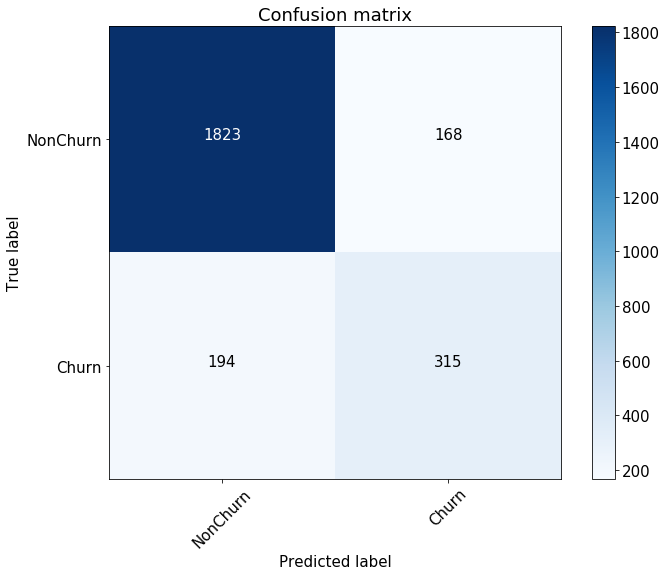

In [15]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [16]:
results=list()
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

#### GradientBoostingClassifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier()),
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ColumnSelector(key='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ColumnSelector(key='Gender')),
                                             

In [19]:
preds = pipeline.predict_proba(X_test)[:, 1]
# preds = pipeline.predict(X_test)
preds[:10]

array([0.30418608, 0.20873054, 0.20415541, 0.0886528 , 0.05449718,
       0.82429074, 0.04252091, 0.06201621, 0.29014233, 0.74181324])

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.333136, F-Score=0.640, Precision=0.629, Recall=0.652


In [21]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.876697101593714

Confusion matrix, without normalization
[[1795  196]
 [ 178  331]]


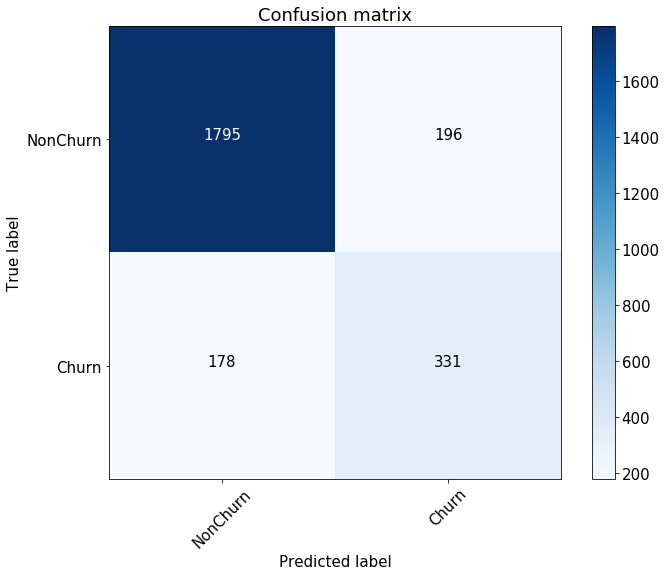

In [22]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [23]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

In [24]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.650294695481336, 0.09844299347061777, 0.9015570065293822)

#### LogisticRegression

In [25]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression()),
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ColumnSelector(key='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ColumnSelector(key='Gender')),
                                             

In [26]:
preds = pipeline.predict_proba(X_test)[:, 1]
# preds = pipeline.predict(X_test)
preds[:10]

array([0.29596157, 0.41976229, 0.19189858, 0.15822608, 0.05224189,
       0.2629274 , 0.02608932, 0.02383127, 0.47485449, 0.4117595 ])

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.306597, F-Score=0.585, Precision=0.526, Recall=0.660


In [28]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8370545647950157

Confusion matrix, without normalization
[[1688  303]
 [ 174  335]]


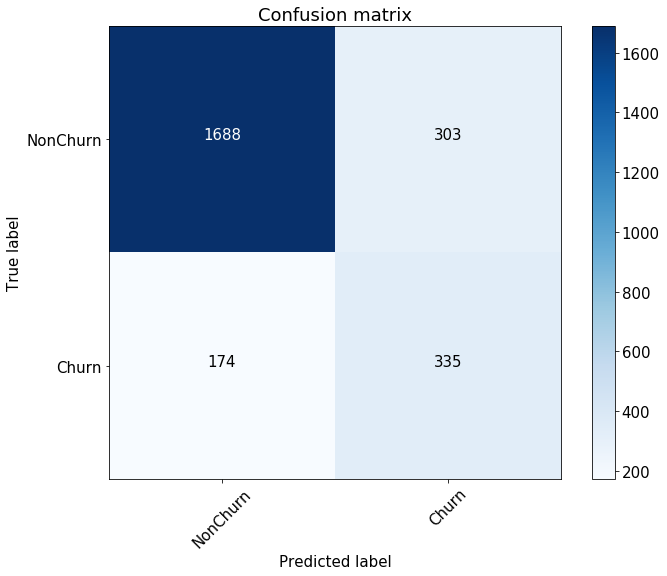

In [29]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [30]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

In [31]:
res = pd.DataFrame(results, columns=['Precision','Recall','Fscore','Roc_auc'])
res['Approach']=['RandomForest','GradientBoosting','LogisticRegression']
res

,Precision,Recall,Fscore,Roc_auc,Approach
0,0.644841,0.638507,0.641658,0.864977,RandomForest
1,0.628788,0.652259,0.640309,0.876697,GradientBoosting
2,0.525822,0.660118,0.585366,0.837055,LogisticRegression


### Задание 2
2.	Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Все метрики достаточно информативны, даже с учетом несбалансированности данных. Лучшие RandomForest, GradientBoosting. Предположу, что в данной задаче более важна полнота(reacall), так как важно определить как можно больше людей потенциально готовых уйти и попробовать их удержать. Таким образом, лучшая модель GradientBoosting.

### Задание 3
3.	Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Здесь снова возможны 4 варианта:
1. Если модель машинного обучения верно предсказывает, что пользователь хочет уйти в отток, то, предложив клиенту скидку (Discount, D), бизнес может заработать на нем сумму, равную пожизненной ценности клиента (LifeTime Value, LTV) минус размер скидки (TP);
2. Если ML прогнозирует уход в отток, а пользователь остается, бизнес теряет размер предложенной скидки (FP);
3. Если по ML-модели клиент остается, а на самом деле он ушел в отток, бизнес теряет все деньги, которые мог бы на нем заработать – LTV (FN).
4. Если пользователь остался, как и предсказала модель ML, в этом конкретном случает от машинного обучения бизнесу нет ни убытка, ни прибыли (FP).

Для упрощения будем считать, что всех выявленных людей, собирающихся уйти (отток), можем удержать выгодным предложением)

In [32]:
TN, FN, TP, FP 

(1795, 178, 331, 196)

In [33]:
profit = (TP+FP)*1 - TP*2
profit

-135

Экономически модель невыгодна.

### Задание 4
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
pipeline = Pipeline([
    ('features',feats)])
X_train_transform = pipeline.fit_transform(X_train)

In [36]:
%%time
gbc = GradientBoostingClassifier()

parametrs = {'loss':['deviance','exponential'],
             'min_samples_split': np.arange(2,4)
            }

gscv = GridSearchCV(estimator=gbc,
                    param_grid=parametrs,
                    scoring='roc_auc',
                    cv=6)

gscv.fit(X_train_transform, y_train)

Wall time: 19.8 s


GridSearchCV(cv=6, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [37]:
cv_results = pd.DataFrame(gscv.cv_results_)
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score']

cv_results = (cv_results[param_columns + score_columns].sort_values(by=score_columns, ascending=False))

cv_results.head(4)

,param_loss,param_min_samples_split,mean_test_score
2,exponential,2,0.864080
3,exponential,3,0.863959
1,deviance,3,0.863202
0,deviance,2,0.862733


In [38]:
gscv.best_params_

{'loss': 'exponential', 'min_samples_split': 2}

In [39]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_split= 2)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]

preds[:10]

array([0.34056418, 0.20488567, 0.14422912, 0.06189685, 0.04575413,
       0.88432014, 0.02821784, 0.05137128, 0.21634728, 0.62200345])

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.299514, F-Score=0.641, Precision=0.595, Recall=0.694


In [41]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8742647414346878

Confusion matrix, without normalization
[[1751  240]
 [ 157  352]]


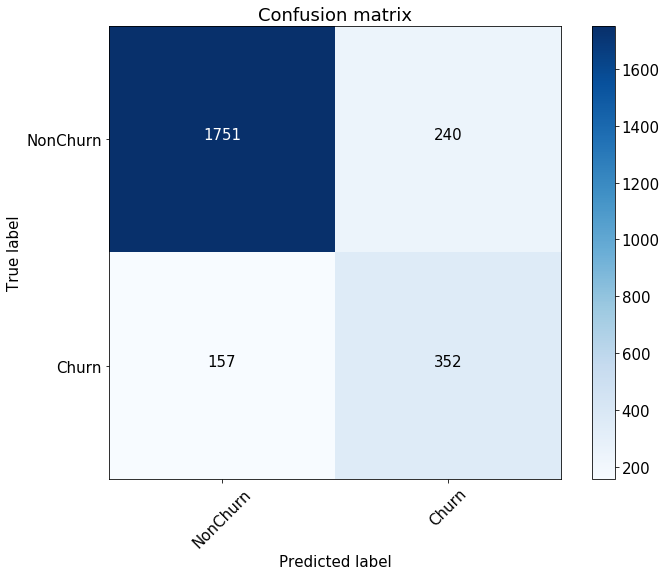

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [43]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

In [44]:
res = pd.DataFrame(results, columns=['Precision','Recall','Fscore','Roc_auc'])
res['Approach']=['RandomForest','GradientBoosting','LogisticRegression', 'UpdateGB' ]
res

,Precision,Recall,Fscore,Roc_auc,Approach
0,0.644841,0.638507,0.641658,0.864977,RandomForest
1,0.628788,0.652259,0.640309,0.876697,GradientBoosting
2,0.525822,0.660118,0.585366,0.837055,LogisticRegression
3,0.595278,0.693517,0.640653,0.874265,UpdateGB


Подбор гиперпараметров не дал значительных результатов.

### Задание 5
5.	(опционально) Еще раз провести оценку экономической эффективности

In [45]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]


TN, FN, TP, FP 

(1751, 157, 352, 240)

In [46]:
profit = (TP+FP)*1 - TP*2
profit

-112

Экономическая эффективность модели UpdateGB выше, чем у GradientBoosting. По метрикам видно, что roc_auc примерно одинаковый, но при этом recall выше.